## Projet Walmart

Régression linéaire... simple... oui, mais avec seulement, 150 lignes dans le dataset !...

L'objectif est de prédire la target 'Weekly_Sales' pour chaque donnée du dataset. Chaque ligne représente le compte des ventes du magasin (identifié par 'Store') accompagné de son chiffre d'affaire hebdomadaire, de la date, ainsi que des données plutôt 'macros' : période de vacances scolaires ou non, température (en degrés °F), prix de carburant dans la zone du magasin, Indice des prix à la consommation ('CPI'), et taux de chômage...

Le problème relèvera peut-être plus, en temps normal, d'une prédiction à faire vis-à-vis d'une série temporelles (pour autant que nous ayons plus de données), mais ici nous allons voir ce que nous allons pouvoir faire avec un modèle de régression linéaire.

Importation des librairies, méthodes et de la donnée :

In [352]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score

In [353]:
dataset = pd.read_csv('src/Walmart_Store_sales.csv')

#### 1/ EDA et choix préalables

In [354]:
dataset

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,6.0,18-02-2011,1572117.54,NaN,59.61,3.045,214.777523,6.858
1,13.0,25-03-2011,1807545.43,0.0,42.38,3.435,128.616064,7.470
2,17.0,27-07-2012,NaN,0.0,NaN,NaN,130.719581,5.936
3,11.0,NaN,1244390.03,0.0,84.57,NaN,214.556497,7.346
4,6.0,28-05-2010,1644470.66,0.0,78.89,2.759,212.412888,7.092
...,...,...,...,...,...,...,...,...
145,14.0,18-06-2010,2248645.59,0.0,72.62,2.780,182.442420,8.899
146,7.0,NaN,716388.81,NaN,20.74,2.778,NaN,NaN
147,17.0,11-06-2010,845252.21,0.0,57.14,2.841,126.111903,NaN
148,8.0,12-08-2011,856796.10,0.0,86.05,3.638,219.007525,NaN


Regardons d'abord les valeurs manquantes :

In [355]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         150 non-null    float64
 1   Date          132 non-null    object 
 2   Weekly_Sales  136 non-null    float64
 3   Holiday_Flag  138 non-null    float64
 4   Temperature   132 non-null    float64
 5   Fuel_Price    136 non-null    float64
 6   CPI           138 non-null    float64
 7   Unemployment  135 non-null    float64
dtypes: float64(7), object(1)
memory usage: 9.5+ KB


Il y a des valeurs manquantes, en faible quantité, dans à peu près chaque feature... Quand on ouvre le fichier sous excel (ce qui est possible car nous avons 150 lignes !), on remarque que les valeurs manquantes sont éparpillées et ne concernent pas les même lignes du dataset. Nous nous occuperons de ces valeurs manquantes pendant le pré-processing...

En revanche, il faut supprimer les lignes où nous avons des valeurs manquantes dans la target :

In [356]:
dataset=dataset.loc[~dataset['Weekly_Sales'].isnull(),:]

On convertit également la date, grâce à la méthode to_datetime() très pratique en pandas, en créant une nouvelle colonne et en supprimant l'ancienne, ce qui permet juste de la renommer en même temps :

In [357]:
dataset['date']=pd.to_datetime(dataset['Date'],infer_datetime_format=True)
dataset.sort_values('date', inplace=True)

C:\Users\PC\AppData\Local\Temp\ipykernel_18372\1026529178.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\AppData\Local\Temp\ipykernel_18372\1026529178.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [358]:
del dataset['Date']

Petite visualisation de 'Weekly_Sales' en fonction du temps, pour se donner une idée de la problématique (attention : ici, les données de ventes sont non groupées par magasin, ainsi nous avons plusieurs ordonnées pour une même abscisse)

In [359]:
fig = px.line(dataset, x='date', y='Weekly_Sales')
fig.update_layout(title_text='weekly sales according to time')
fig.show()

Seconde visuation des Weekly_Sales, mais cette fois-ci en groupant tous les chiffres d'affaire des magasins pour une même date :

In [360]:
fig = px.line(x=dataset['date'].unique()[:79], y=dataset.groupby('date').sum()['Weekly_Sales'])
fig.update_layout(title_text='weekly sales according to time')
fig.show()

Le graphique est plus parlant. Problème tout de même : nous n'avons pas les chiffres d'affaire de chaque magasin pour chaque date (notre dataset ferait alors quelque chose comme 132 semaines (environ) * 20 magasins = 2640 lignes !...) donc ces données agrégées ne sont pas réalistes, par rapport au véritable chiffre d'affaire total...

C'est dommage, nous aurions nous donner comme objectif final de comparer nos prédictions avec ce deuxième graphique qui donne un chiffre d'affaire total sur l'ensemble des magasins. En Machine Learning appliqué aux séries temporelles, c'est ce que nous fairions dès le départ en prenant en input les données aggrégées par date. En Régression Linéaire, mieux vaut tenter de prédire le chiffre d'affaire par date et par magasin (pour ne pas perdre trop d'infos, déjà que nous n'avons que 150 lignes !...) pour ensuite faire la somme (par date) de nos prédictions.

Ici, on ajoute des données pour tenter d'exploiter la date en mode Régression Linéaire, donc on ajoute les features 'Year', 'Month', 'Day', Dayofweek', etc...

In [361]:
dataset['Year']=dataset['date'].apply(lambda d : d.year)
dataset['Month']=dataset['date'].apply(lambda d : d.month)
dataset['Day']=dataset['date'].apply(lambda d : d.day)
dataset['Day_of_year']=dataset['date'].apply(lambda d : d.day_of_year)
dataset['Day_of_week']=dataset['date'].apply(lambda d : d.day_of_week)

C:\Users\PC\AppData\Local\Temp\ipykernel_18372\2933010254.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\AppData\Local\Temp\ipykernel_18372\2933010254.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\AppData\Local\Temp\ipykernel_18372\2933010254.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [362]:
dataset.head()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,date,Year,Month,Day,Day_of_year,Day_of_week
67,3.0,461622.22,0.0,45.71,2.572,214.424881,7.368,2010-02-05,2010.0,2.0,5.0,36.0,4.0
44,1.0,1641957.44,1.0,38.51,2.548,211.242170,8.106,2010-02-12,2010.0,2.0,12.0,43.0,4.0
107,8.0,994801.40,1.0,33.34,2.548,214.621419,6.299,2010-02-12,2010.0,2.0,12.0,43.0,4.0
115,15.0,660838.75,0.0,NaN,2.909,131.637000,NaN,2010-02-19,2010.0,2.0,19.0,50.0,4.0
112,2.0,2124451.54,0.0,39.69,2.514,210.945160,NaN,2010-02-19,2010.0,2.0,19.0,50.0,4.0


C'est maintenant que l'on peut faire un 'describe' pour tenter d'analyser toutes les features et commencer à repérer certains éventuels problèmes dans les données (aberrations, outliers...) :

In [363]:
dataset.describe(include='all', datetime_is_numeric=True)

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,date,Year,Month,Day,Day_of_year,Day_of_week
count,136.000000,1.360000e+02,125.000000,121.000000,124.000000,125.000000,122.000000,118,118.000000,118.000000,118.000000,118.000000,118.0
mean,10.014706,1.249536e+06,0.072000,60.853967,3.316992,178.091144,7.665582,2011-04-23 04:28:28.474576384,2010.822034,6.338983,16.440678,178.144068,4.0
min,1.000000,2.689290e+05,0.000000,18.790000,2.514000,126.111903,5.143000,2010-02-05 00:00:00,2010.000000,1.000000,1.000000,6.000000,4.0
25%,4.000000,6.050757e+05,0.000000,45.220000,2.838500,131.637000,6.690000,2010-07-30 00:00:00,2010.000000,4.000000,10.000000,107.250000,4.0
50%,10.000000,1.261424e+06,0.000000,62.250000,3.451000,196.919506,7.477000,2011-04-29 00:00:00,2011.000000,6.000000,16.500000,174.000000,4.0
75%,15.250000,1.806386e+06,0.000000,75.950000,3.724000,214.878556,8.150000,2011-12-31 18:00:00,2011.750000,9.000000,24.000000,252.500000,4.0
max,20.000000,2.771397e+06,1.000000,91.650000,4.193000,226.968844,14.313000,2012-10-19 00:00:00,2012.000000,12.000000,31.000000,365.000000,4.0
std,6.124614,6.474630e+05,0.259528,18.514432,0.479540,40.243105,1.619428,NaN,0.812628,3.173664,8.209378,96.688704,0.0


Quelques remarques :
- nos magasins sont identifiés visiblement de 1 à 20
- 'Holiday Flag' ne prend que deux valeurs 0 et 1 ce qui doit correspondre à 'en vacances / pas en vacances'
- La température est en degrés Fahrenheit
- pas de min ou de max qui paraissent aberrants dans toutes les features...

On poursuit avec un affichage des différentes distributions de variables, catégorielles et numériques à la fois... On couple avec un affichage des données de la target en fonction de chaque feature, pour regarder si déjà à ce stade, on trouve de potentielles corrélations :

In [364]:
import matplotlib.pyplot as plt
import plotly.express as px

for col in dataset.columns:
    fig = px.scatter(dataset, x=col, y='Weekly_Sales', width=800, height=350, marginal_x='histogram')
    fig.show()

Quelques remarques :
- On voit bien que certains magasins vendent bien plus que d'autres (malheureusement, on ne possède pas la surface de chaque magasin, nous aurions pu 'normaliser' les ventes !)
- Le '1' de 'Holiday semble correspondre aux périodes de vacances, plus rares que le '0'
- La température possède une distribution assez homogène mais Fuel Price et CPI sont formés en ''double tas''
- 'Unemployment' possède visiblement des outliers qu'il conviendrait de retirer pour le bon fonctionnement du modèle
- On a plus de données en 2010, qu'en 2011, qu'en 2012...
- Avec les features 'Day_of_Year' et 'Month' on voit qu'il y a beaucoup de ventes en décembre, plus que les autres mois.

Dernière remarque : 'Day of week' est constamment égale à 4 pour toutes les données. (remontées des ventes le jeudi dans tous les magasins ?...). On peut donc s'empresser de supprimer la colonne :

In [365]:
del dataset['Day_of_week']

Ensuite, on supprime les outliers pour 'Unemployment'. Comme on a très très peu de données, elles sont précieuses. Aussi, les lignes ne sont pas supprimées mais remplacées par la moyenne :

In [366]:
Un_mean = dataset['Unemployment'].mean()
Un_std = dataset['Unemployment'].std()
dataset['Unemployment'] = dataset['Unemployment'].apply(lambda v : v if abs(v - Un_mean) <= 3*Un_std \
                                                                        or str(v)=='nan' \
                                                                     else Un_mean)

C:\Users\PC\AppData\Local\Temp\ipykernel_18372\1161550899.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [367]:
dataset['Unemployment'].describe()

count    122.000000
mean       7.410335
std        0.974801
min        5.143000
25%        6.690000
50%        7.477000
75%        8.096750
max        9.524000
Name: Unemployment, dtype: float64

In [368]:
len(dataset)

136

Dernière étape de cette EDA, on visualise la matrice de corrélation, avec les taux en valeurs absolues...

<AxesSubplot:>

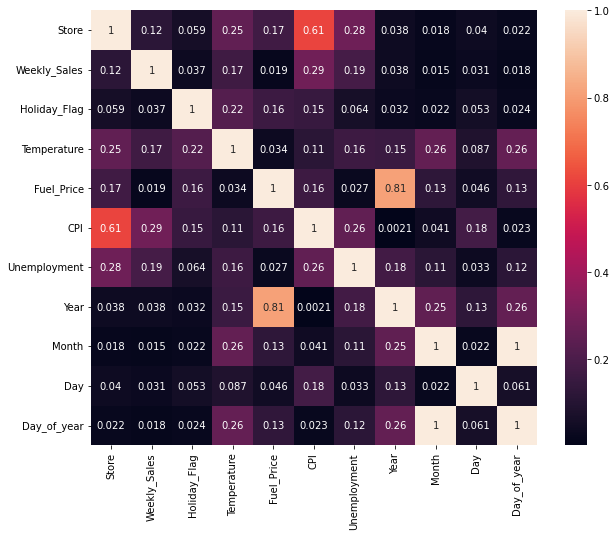

In [369]:
plt.figure(figsize=(10,8))
data_corr=dataset.corr()
sns.heatmap(abs(data_corr),annot=True)

Outre les corrélations inter-features, on observe avant tout 'Weekly_Sales' en fonction des features... Les corrélations sont assez faibles, mais le CPI se démarque, ainsi qu' 'Unemployment' et 'Temperature' dans un second temps... Il s'agira de nos trois premières features.

#### 2/ Simple Regression Linéaire et choix des features

En réalité, nous avons commencé par la seule feature 'CPI' pour 'voir'... mais cela n'a rien donné, et préférons ne pas surcharger ce notebook en présentant TOUS les essais infructueux, mais seulement quelqu'uns de ces essais caractéristiques...

Donc on prend ici les trois features numériques avec le plus de corrélation apparente avec la target :

In [370]:
X = dataset[['CPI', 'Temperature', 'Unemployment']]
Y = dataset['Weekly_Sales']

Pas encore de données catégorielles, mais ici j'ai formaté le code pour anticiper sur la suite :

In [371]:
numeric_features = ['CPI', 'Temperature', 'Unemployment']
categorical_features = []

Train test splitting :

In [372]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

On créé la Pipeline du préprocessing.

On utilise un KNN comme Imputer des valeurs numériques. En effet, cet imputer, qui remplace les valeurs manquantes en fonction de la ressemblance avec les données 'voisines', va permettre un plus subtil remplacement dans notre cas : nous avons peu de lignes, donc il s'agirait de ne pas surcharger la moyenne ou la médiane, d'autant que deux des features 'Fuel Price' et CPI sont en distribution de double bosse (il s'agirait de ne pas créer une troisième bosse en plein milieu qui pourrait altérer cette distribution.)

In [373]:
numeric_transformer = Pipeline(
    steps=[
        ('imputer', KNNImputer(n_neighbors=10)),
        ('scaler',StandardScaler())
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder',OneHotEncoder(drop='first'))
    ]
)

In [374]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num',numeric_transformer,numeric_features),
        ('cat',categorical_transformer,categorical_features)
    ])

Preprocessing sur les données d'entraînement et de tests :

In [375]:
X_train=preprocessor.fit_transform(X_train)
X_test=preprocessor.transform(X_test)

Emploi du modèle de régression Linéaire (le plus simple qui soit) :

In [376]:
regressor=LinearRegression()
regressor.fit(X_train, Y_train)

LinearRegression()

Entraînement sur les données et premiers résultats avec le score R2 sur le train set et le test set :

In [377]:
Y_pred = regressor.predict(X_train)
Y_test_pred = regressor.predict(X_test)
print (f'R2_score sur le train set : {r2_score(Y_train, Y_pred)}')
print (f'R2_score sur le test set : {r2_score(Y_test, Y_test_pred)}')

R2_score sur le train set : 0.08160248357538291
R2_score sur le test set : 0.16347552172593083


Ce n'est vraiment pas fameux !... On regarde avec score R2 de validation croisée :

In [378]:
print (f'Cross_Val_Score MEAN sur le train set : {cross_val_score(regressor,X_train, Y_train, cv=7).mean()}')
print (f'Cross_Val_Score Std sur le train set : {cross_val_score(regressor,X_train, Y_train, cv=7).std()}')


Cross_Val_Score MEAN sur le train set : -0.04367869411239297
Cross_Val_Score Std sur le train set : 0.13190919368653659


Hum... On va prendre plus de features ?...

Allez, on ajoute presque tout. Notre dernière variable numérique 'Fuel_Price' mais aussi trois features catégorielles : 'Holiday_Flag', 'Year' et 'Month'... pour l'instant on écarte les features catégorielles non ordinales qui ont trop de valeurs possibles, cela va faire exploser la dimensionnalité du dataset, et on rique l'over-fitting...

In [379]:
X = dataset[['CPI', 'Temperature', 'Unemployment', 'Fuel_Price', 'Holiday_Flag', 'Year', 'Month']]
numeric_features = ['CPI', 'Temperature', 'Unemployment', 'Fuel_Price']
categorical_features = ['Holiday_Flag', 'Year', 'Month']

preprocessor = ColumnTransformer(
    transformers=[
        ('num',numeric_transformer,numeric_features),
        ('cat',categorical_transformer,categorical_features)
    ])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train=preprocessor.fit_transform(X_train)
X_test=preprocessor.transform(X_test)
regressor.fit(X_train, Y_train)
Y_pred = regressor.predict(X_train)
Y_test_pred = regressor.predict(X_test)
print (f'R2_score sur le train set : {r2_score(Y_train, Y_pred)}')
print (f'R2_score sur le test set : {r2_score(Y_test, Y_test_pred)}')
print (f'Cross_Val_Score MEAN sur le train set : {cross_val_score(regressor,X_train, Y_train, cv=7).mean()}')
print (f'Cross_Val_Score Std sur le train set : {cross_val_score(regressor,X_train, Y_train, cv=7).std()}')

R2_score sur le train set : 0.2633337405402738
R2_score sur le test set : 0.20893276364644053
Cross_Val_Score MEAN sur le train set : -0.11919566225325097
Cross_Val_Score Std sur le train set : 0.24789002435311364


Le R2 score du train set est à peine meilleur... En validation croisé, il devient alarmant. Et la variance du résultat est grande...

Un R2 négatif ? Cela veut dire qu'on est moins bon qu'un modèle qui prédirait tout le temps une valeur constante à la moyenne du chiffre d'affaire total de tous les magasins.

 Allez, dernier espoir, on ajoute la feature 'Store', grande oubliée de notre baseline... En revanche, comme on ajoute une feature avec, tout de même 20 valeurs uniques (ce qui va ajouter 19 colonnes), on va éviter de mettre les features 'Day' et 'Day_of_Week' qui, ce coup-ci, feraient exploser la dimensionalité...

In [380]:
baseline = ['CPI', 'Temperature', 'Unemployment', 'Fuel_Price', 'Holiday_Flag', 'Year', 'Month', 'Store']
X = dataset[baseline]
numeric_features = ['CPI', 'Temperature', 'Unemployment', 'Fuel_Price']
categorical_features = ['Holiday_Flag', 'Year', 'Month', 'Store']

preprocessor = ColumnTransformer(
    transformers=[
        ('num',numeric_transformer,numeric_features),
        ('cat',categorical_transformer,categorical_features)
    ])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train=preprocessor.fit_transform(X_train)
X_test=preprocessor.transform(X_test)
regressor.fit(X_train, Y_train)
Y_pred = regressor.predict(X_train)
Y_test_pred = regressor.predict(X_test)
print (f'R2_score sur le train set : {r2_score(Y_train, Y_pred)}')
print (f'R2_score sur le test set : {r2_score(Y_test, Y_test_pred)}')
print (f'Cross_Val_Score MEAN sur le train set : {cross_val_score(regressor,X_train, Y_train, cv=7).mean()}')
print (f'Cross_Val_Score Std sur le train set : {cross_val_score(regressor,X_train, Y_train, cv=7).std()}')

R2_score sur le train set : 0.9878734139042445
R2_score sur le test set : 0.9214437629543654
Cross_Val_Score MEAN sur le train set : 0.9649466397414862
Cross_Val_Score Std sur le train set : 0.014252240263738364


Incroyable ! On est très très bons sur le train set et également sur le test set... malgré un assez léger overfitting... (résultat sur le test set à environ 2 à 3 déviations standards du score moyen sur le train set)

À bien y réfléchir, est-ce si incroyable ? On avait vu que selon le magasin, les ventes (et les autres features) changeaient du tout au tout. Il nous manquait effectivement cette feature indispensable pour que le modèle fonctionne. La feature 'Store' détermine grandement les chiffres de vente.

#### 3/ Modèles avec régularisations

Nous allons tenter de corriger le léger overfitting...

Tout d'abord avec un modèle de Ridge régression (on commence plus doux)

Ici, on a lancé plusieurs gridsearchs pour trouver les bons paramètres. Par méthode d'encadrement itératifs, on touve la bonne valeur pour le coefficient de régularisation alpha. Dans le code, on a laissé la dernière valeur trouvée, encadrée avec précision :

In [381]:
regressor=Ridge()
params={
    'alpha':[0.9, 0.1, 0.11]
}

grid_search=GridSearchCV(regressor,param_grid=params,cv=10)

In [382]:
grid_search.fit(X_train,Y_train)

GridSearchCV(cv=10, estimator=Ridge(), param_grid={'alpha': [0.9, 0.1, 0.11]})

In [383]:
grid_search.best_params_

{'alpha': 0.1}

In [384]:
Y_pred = grid_search.best_estimator_.predict(X_train)
Y_test_pred = grid_search.best_estimator_.predict(X_test)

print (f'R2_score sur le train set : {r2_score(Y_train, Y_pred)}')
print (f'R2_score sur le test set : {r2_score(Y_test, Y_test_pred)}')
print (f'Cross_Val_Score MEAN sur le train set : {cross_val_score(grid_search.best_estimator_,X_train, Y_train, cv=7).mean()}')
print (f'Cross_Val_Score Std sur le train set : {cross_val_score(grid_search.best_estimator_,X_train, Y_train, cv=7).std()}')

R2_score sur le train set : 0.986317560117379
R2_score sur le test set : 0.9168987775958741
Cross_Val_Score MEAN sur le train set : 0.9641388462302951
Cross_Val_Score Std sur le train set : 0.015149412074408593


Cela ne change pas grand chose. Essayons le modèle Lasso, qui devrait offrir une meilleure régularisation...

In [385]:
regressor=Lasso()
params={
    'alpha':[350, 355, 360]
}

grid_search=GridSearchCV(regressor,param_grid=params,cv=10)

In [386]:
grid_search.fit(X_train,Y_train)
grid_search.best_params_

{'alpha': 355}

In [387]:
Y_pred = grid_search.best_estimator_.predict(X_train)
Y_test_pred = grid_search.best_estimator_.predict(X_test)

print (f'R2_score sur le train set : {r2_score(Y_train, Y_pred)}')
print (f'R2_score sur le test set : {r2_score(Y_test, Y_test_pred)}')
print (f'Cross_Val_Score MEAN sur le train set : {cross_val_score(grid_search.best_estimator_,X_train, Y_train, cv=7).mean()}')
print (f'Cross_Val_Score Std sur le train set : {cross_val_score(grid_search.best_estimator_,X_train, Y_train, cv=7).std()}')

R2_score sur le train set : 0.9872733718126937
R2_score sur le test set : 0.9238605225938141
Cross_Val_Score MEAN sur le train set : 0.9670765893579242
Cross_Val_Score Std sur le train set : 0.01486400026015584


C'est un peu mieux, mais ce n'est pa encore idéal. Peut-être en retirant quelques features ? Pour cela, tentons d'analyser les coefficients de notre modèle Lasso...

In [388]:
grid_search.best_estimator_.coef_

array([   33021.5188159 ,       -0.        ,   -58155.97742167,
         -12233.94122364,    76378.54024926,       -0.        ,
         -39511.97914855,    69694.44467936,    55294.24657829,
         -23430.69157182,    35090.13685454,    75688.13758283,
             -0.        ,    53261.78529823,   -18671.53756446,
             -0.        ,    77530.25721827,   560599.13606911,
         350901.08873091, -1134693.95877892,   491319.58403621,
       -1268532.58313297,        0.        ,  -871420.45327871,
        -734210.2801566 , -1109548.71348066,   442816.55109521,
         -54505.65122271,  -511385.84362018,   445024.05640317,
         605598.25364085,  -804427.59945195, -1051856.72320856,
        -617846.64177695,  -256076.61890465,    35042.3886034 ,
         408816.59824158])

Il va falloir faire la jonction entre ces coefficients et les 'features' pour tenter d'y comprendre quelque chose.

In [389]:
preprocessor.feature_names_in_

array(['CPI', 'Temperature', 'Unemployment', 'Fuel_Price', 'Holiday_Flag',
       'Year', 'Month', 'Store'], dtype=object)

In [390]:
preprocessor.output_indices_

{'num': slice(0, 4, None),
 'cat': slice(4, 37, None),
 'remainder': slice(0, 0, None)}

In [391]:
len(dataset['Store'].unique())

20

On essai de reconstituer la liste des features pour pouvoir les associer aux coefficients. Ce n'est pas évident car nous avons en plus beaucoup de features catégorielles qui ont créé nombre de colonnes après le préprocessing ! Il suffit de les intégrer dans l'ordre du 'preprocessor.feature_name_in_', accompagnées d'index, sans oublier l'effet du 'drop first' dans le OneHotEncoder du preprocessing...

In [392]:
features_list_preproc = []
features_list_preproc.extend(['CPI', 'Temperature', 'Unemployment', 'Fuel_Price', 'Holiday_Flag'])
features_list_preproc.extend([f'Year_{i}' for i in range(1,3)])
features_list_preproc.extend([f'Month_{i}' for i in range(1,12)])
features_list_preproc.extend([f'Store_{i}' for i in range(1,20)])

In [393]:
len(features_list_preproc)

37

In [394]:
import plotly.express as px

podium_coef = pd.DataFrame(grid_search.best_estimator_.coef_, index=features_list_preproc, columns=['coeff_value'])
podium_coef['coeff_value']=round(podium_coef['coeff_value'],2)

fig = px.bar(podium_coef, title='Coefficients importance by features')
fig.show()

On voit se dessiner clairement l'importance des 'Stores', comme cela était attendu... Certains 'months' ont été complètement neutralisés par le modèle de régularisation Lasso, tout comme la Température et l'année 2010. 

Pour réduire la dimensionalité du dataset, après réflexion, le mieux à tenter serait d'enlever au final la feature 'Month', car le bénéfice d'une telle suppression risque d'être assez convainquant sur l'overfitting, puisque cela concerne 11 features (après preprocessing).

Voici donc notre modèle le plus abouti :

In [395]:
baseline = ['CPI', 'Temperature', 'Unemployment', 'Fuel_Price', 'Holiday_Flag', 'Store']
X = dataset[baseline]
numeric_features = ['CPI', 'Temperature', 'Unemployment', 'Fuel_Price']
categorical_features = ['Holiday_Flag', 'Store']

preprocessor = ColumnTransformer(
    transformers=[
        ('num',numeric_transformer,numeric_features),
        ('cat',categorical_transformer,categorical_features)
    ])

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X_train=preprocessor.fit_transform(X_train)
X_test=preprocessor.transform(X_test)

In [396]:
regressor=Lasso()
params={
    'alpha':[735, 740, 745]
}

grid_search=GridSearchCV(regressor,param_grid=params,cv=10)

In [397]:
grid_search.fit(X_train,Y_train)
grid_search.best_params_

{'alpha': 740}

In [398]:
regressor.fit(X_train, Y_train)
Y_pred = regressor.predict(X_train)
Y_test_pred = regressor.predict(X_test)
print (f'R2_score sur le train set : {r2_score(Y_train, Y_pred)}')
print (f'R2_score sur le test set : {r2_score(Y_test, Y_test_pred)}')
print (f'Cross_Val_Score MEAN sur le train set : {cross_val_score(regressor,X_train, Y_train, cv=7).mean()}')
print (f'Cross_Val_Score Std sur le train set : {cross_val_score(regressor,X_train, Y_train, cv=7).std()}')

R2_score sur le train set : 0.9623393724347775
R2_score sur le test set : 0.9303473534347163
Cross_Val_Score MEAN sur le train set : 0.9252272538164618
Cross_Val_Score Std sur le train set : 0.02815577021170363


Un résultat de test à peine 1 déviation standard du train set... et même confondu, à peu de choses près, au résultat sur le score de valeurs croisées du train set... C'est gagné, il n'y a plus d'overfitting ! On a perdu quelques points en performance mais le modèle semble équilibré.

#### 4/ Optionnel en plus : Test du modèle dans une perspective de prévision temporelle

Ici, nous aimerions tester notre modèle dans une configuration plus réaliste et adaptée, un peu comme si nous avions affaire à une série temporelle.

Il s'agit simplement de séparer notre train set et notre test set par DATES. On se place ainsi dans une configuration où nous posséderions des données sur le passé (le train set) pour prédire les résultats futurs (le test set), car ce serait, au final, l'intérêt d'un tel modèle de Machine Learning pour une enseigne de magasins.

Cela pose deux problèmes de fond : 
- comme nous l'avons dit précedemment, l'intérêt d'une telle prédiction supposerait, pour nos données passées, d'avoir l'ensemble des chiffres d'affaires de chaque magasin pour pouvoir sommer ces CA de la même manière à chaque date... or là nous n'avons qu'à chaque fois 2 à 3 chiffre d'affaire de chaque magasin sur chaque date, pris un peu au hasard... pas de quoi faire une somme crédible...
- il faut se placer dans un univers un peu abstrait où nous aurions les données du test set : c'est-à-dire les données précises, pour les X prochaines semaines, de variables telles que le taux de chômage, l'indice du taux de consommation, le prix du fuel (pourtant assez instable), la température (alors que nous savons qu'il est difficile de faire des prévisions météo à plus de 5-6 jours...) Notre modèle serait donc un modèle devenu prédictif à partir de d'autres données elles-même issues de prévisions, plus ou moins fiables, d'une semaine à l'autre... Il faut donc prendre tout cela avec des pincettes...

Admettons qu'avec plus de données, et des prévisions fiables de nos features à 1 semaine, tout ceci soit possible, et testons l'idée, seulement à titre d'exercice et pour pouvoir le comparer à un modèle de série temporelle !...

On commence donc par reprendre notre dataset mais en supprimant les données pour lesquelles nous n'avons pas l'information 'date' :

In [399]:
dataset = dataset.loc[~dataset['date'].isnull(),:].reset_index()

In [400]:
del dataset['index']

In [401]:
len(dataset)

118

On effectue donc notre split train/test temporellement, en gardant environ 80% des données en train set (passé) et 20% environ des données en test set (futur)

In [402]:
data_train = dataset.iloc[:95,:]
data_test = dataset.iloc[95:,:]

In [403]:
Y_train=data_train['Weekly_Sales']
Y_test=data_test['Weekly_Sales']

Puis on créé un nouveau modèle Lasso sur la base du dernier modèle retenu précedemment :

In [404]:
X_train = preprocessor.fit_transform(data_train[baseline])
X_test = preprocessor.transform(data_test[baseline])

In [405]:
regressor=Lasso(alpha=740, max_iter=10000)

regressor.fit(X_train, Y_train)

Lasso(alpha=740, max_iter=10000)

In [406]:
Y_pred = regressor.predict(X_train)
Y_test_pred = regressor.predict(X_test)
print (f'R2_score sur le train set : {r2_score(Y_train, Y_pred)}')
print (f'R2_score sur le test set : {r2_score(Y_test, Y_test_pred)}')
print (f'Cross_Val_Score MEAN sur le train set : {cross_val_score(regressor,X_train, Y_train, cv=7).mean()}')
print (f'Cross_Val_Score Std sur le train set : {cross_val_score(regressor,X_train, Y_train, cv=7).std()}')

R2_score sur le train set : 0.9533721546137865
R2_score sur le test set : 0.9753825222373576
Cross_Val_Score MEAN sur le train set : 0.8855210358802671
Cross_Val_Score Std sur le train set : 0.09483513657286412


Nous conservons nos performances, visiblement, qui sont même légèrement meilleur que précedemment. En revanche, l'incertitude sur nos coss val score est plus grande. Cela provient sans doute de l'instabilité de nos résultats depuis le début de ce notebook... car nous travaillons de toutes les façons sur trop peu de lignes.

Pour finir, nous allons tenter de visualiser temporellement nos écarts de mesure entre les données réelles et les données prédites.

C:\Users\PC\AppData\Local\Temp\ipykernel_18372\3417756735.py:15: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



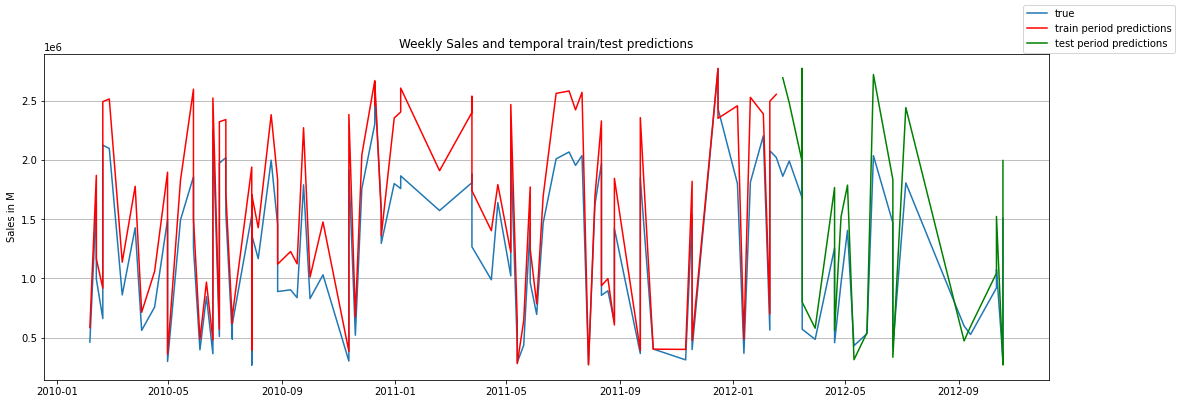

In [407]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(18,6))
plt.ylabel('Sales in M')
ax1.plot(dataset['date'], dataset['Weekly_Sales'], label='true')
ax1.grid(True, axis='y')
ax2 = ax1.twinx()
ax2.plot(data_train['date'], Y_pred, color='r', label='train period predictions')
ax2.axis('off')
ax3 = ax1.twinx()
ax3.plot(data_test['date'], Y_test_pred, color='g', label='test period predictions')
fig.legend()
ax3.axis('off')
plt.title('Weekly Sales and temporal train/test predictions')
fig.show()

Ici, nous avons repris notre première visualisation. 

En rouge, la partie train - en vert, la partie test - en bleu, les données réelles. 

On voit que notre modèle colle assez bien aux données réelles.

Deuxième étape : on visualise nos prédictions sur l'ensemble des données de ventes agrégées, c'est-à-dire le chiffre d'affaire total de l'enseigne, tout magasin confondu.

In [408]:
data_train['Y_pred'] = Y_pred
data_test['Y_test_pred'] = Y_test_pred

C:\Users\PC\AppData\Local\Temp\ipykernel_18372\1456439012.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\PC\AppData\Local\Temp\ipykernel_18372\1456439012.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



C:\Users\PC\AppData\Local\Temp\ipykernel_18372\2603730697.py:13: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



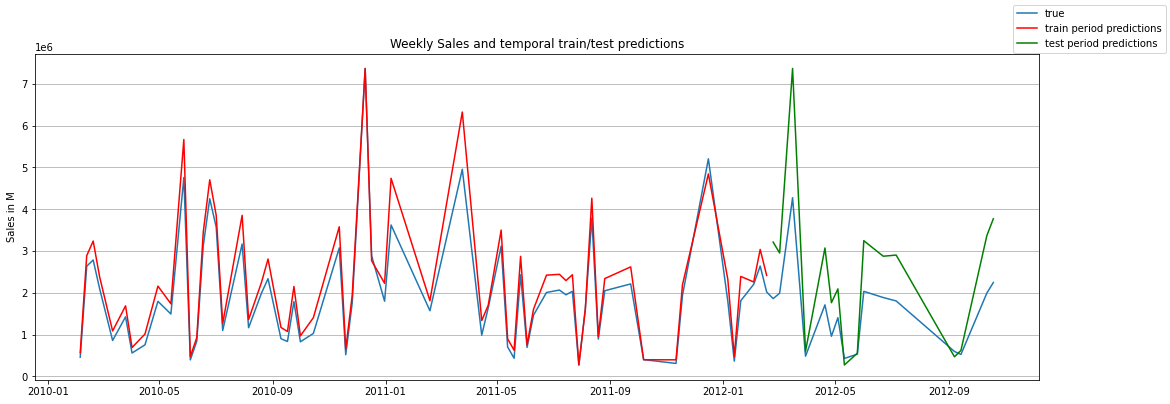

In [409]:
fig, ax1 = plt.subplots(figsize=(18,6))
plt.ylabel('Sales in M')
ax1.plot(dataset['date'].unique(), dataset.groupby('date').sum()['Weekly_Sales'], label='true')
ax1.grid(True, axis='y')
ax2 = ax1.twinx()
ax2.plot(data_train['date'].unique(), data_train.groupby('date').sum()['Y_pred'], color='r', label='train period predictions')
ax2.axis('off')
ax3 = ax1.twinx()
ax3.plot(data_test['date'].unique(), data_test.groupby('date').sum()['Y_test_pred'], color='g', label='test period predictions')
fig.legend()
ax3.axis('off')
plt.title('Weekly Sales and temporal train/test predictions')
fig.show()

C'est asssez parlant là encore. On distingue, par contre, une surestimation des vente (minimes dans les données train mais plus dramatique dans les données tests) surtout lorsqu'il y a des pics.

En revanche, comment dans une période future, serait-il possible d'avoir les données précises de 'Fuel Price', 'Temperature' 'CPI'... etc ? Il faudrait pouvoir faire ces prédictions à 7 jours, de manière suffisamment précise... ce qui nous amène beaucoup d'autres questions.

Tentons maintenant de comparer ce modèle à un modèle prédictif spécialement conçu pour les séries temporelles tel que Prophet.

On commence par agréger les données, pour cela on repart de nos data_train et data_test déjà splittés temporellement :

In [410]:
data_train_sales = data_train.groupby('date').sum()['Weekly_Sales']
data_test_sales = data_test.groupby('date').sum()['Weekly_Sales']

Ici on vérifie que la série temporelle est bien stationnaire :

In [411]:
import statsmodels.api as sm

autocor = pd.Series(sm.tsa.stattools.pacf(data_train_sales))

In [412]:
fig = px.bar(x=autocor.index,y=autocor)
fig.show()

Cela a l'air bon... On a bien affaire à une série temporelle stationnaire. On stocke notre data dans deux dataframes :

In [413]:
data_train_sales = pd.DataFrame({'ds':data_train_sales.index,'y':data_train_sales.values})
data_test_sales = pd.DataFrame({'ds':data_test_sales.index})

Génération et entrainement du modèle sur les données train :

In [414]:
from prophet import Prophet

In [415]:
m = Prophet()
m.fit(data_train_sales)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\Users\PC\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Prévisions sur les données futures (test set) :

In [416]:
forecast = m.predict(data_test_sales)

c:\Users\PC\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\Users\PC\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Visualisation des données prédites et comparaison avec notre autre modèle :

C:\Users\PC\AppData\Local\Temp\ipykernel_18372\1837626192.py:14: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



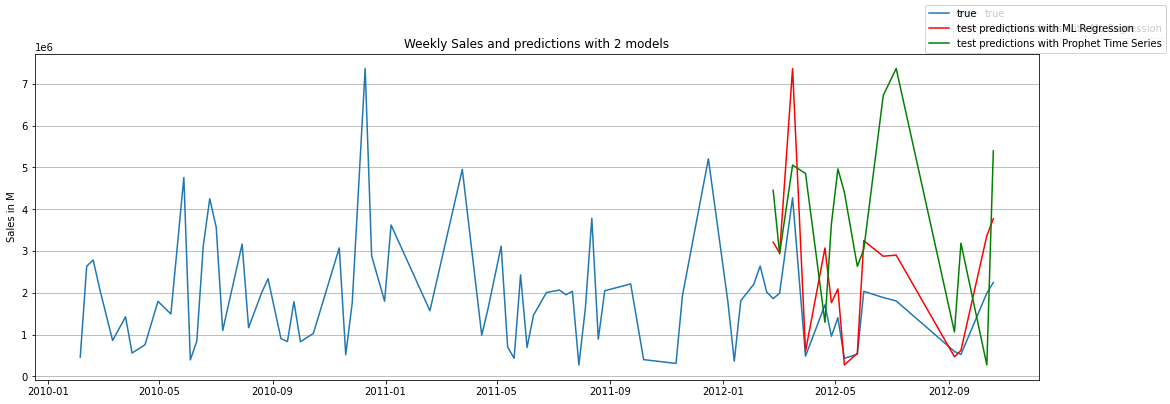

In [417]:
fig, ax1 = plt.subplots(figsize=(18,6))
plt.ylabel('Sales in M')
ax1.plot(dataset['date'].unique(), dataset.groupby('date').sum()['Weekly_Sales'], label='true')
ax1.grid(True, axis='y')
ax2 = ax1.twinx()
ax2.plot(data_test['date'].unique(), data_test.groupby('date').sum()['Y_test_pred'], color='r', label='test predictions with ML Regression')
fig.legend()
ax2.axis('off')
ax3 = ax1.twinx()
ax3.plot(data_test['date'].unique(), forecast['yhat'], color='g', label='test predictions with Prophet Time Series')
fig.legend()
ax3.axis('off')
plt.title('Weekly Sales and predictions with 2 models')
fig.show()

On voit que notre modèle de Régression Linéaire Lasso semble bien plus proche de la réalité que le modèle prédictif Prophet.

Mais attention, qu'est-ce que nous sommes vraiment en train de comparer ?
- pour le modèle de Regression Linéaire, le modèle a accès à toutes les données futures (hormis la target) comme si nous étions capables de les avoir à tous instants (Fuel_Price, Temperature, etc...)
- pour le modèle Prophet, il ne possède que les données passées de manière stricte. Et on lui demande d'effectuer des prévisions sur plusieurs mois, ce qui est beaucoup trop pour un tel modèle, avec si peu de données !...

On décide, donc, pour rendre plus crédible notre modèle Prophet rival, d'imaginer qu'il effectue des prévisions à 5 jours sucessives (en ayant sucessivement toutes les données passées en 'history')... Il existe un outil pour cela, la cross_ validation de la librairie Prophet.

Pour pouvoir utiliser l'outil, il faut ré-agréger les données de ventes totales sur, cette fois, l'ensemble du dataset (plus de train set et de test set, l'outil corss_validation créé lui-même les 'cutoff' successifs qui vont être effectués sur les dates) :

In [418]:
data_sales_total = dataset.groupby('date').sum()['Weekly_Sales']

In [419]:
data_sales_total = pd.DataFrame({'ds':data_sales_total.index,'y':data_sales_total.values})

On créé un nouveau modèle de prédiction avec Prophet et on l'entraîne :

In [420]:
m2 = Prophet()

m2.fit(data_sales_total)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\Users\PC\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



Les données sont entraînées sur l'ensemble de la période, ce qui paraît étrange, mais c'est le seul moyen d'utiliser l'outil cross_validation qui va lui-même, ensuite, ignorer successivement une partie du dataset :

In [421]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(m2, initial='750 days', period='5 days', horizon = '5 days')

INFO:prophet:Making 15 forecasts with cutoffs between 2012-02-26 00:00:00 and 2012-10-14 00:00:00


  0%|          | 0/15 [00:00<?, ?it/s]

c:\Users\PC\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\Users\PC\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\Users\PC\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\Users\PC\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

c:\Users\PC\anaconda3\lib\site-packages\prophet\forecaster.py:896: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat 

C:\Users\PC\AppData\Local\Temp\ipykernel_18372\908681974.py:17: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



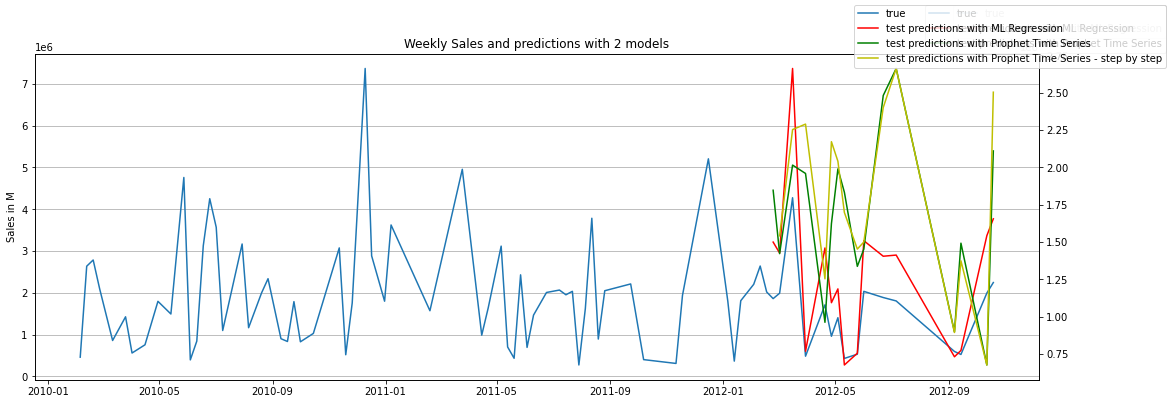

In [423]:
fig, ax1 = plt.subplots(figsize=(18,6))
plt.ylabel('Sales in M')
ax1.plot(dataset['date'].unique(), dataset.groupby('date').sum()['Weekly_Sales'], label='true')
ax1.grid(True, axis='y')
ax2 = ax1.twinx()
ax2.plot(data_test['date'].unique(), data_test.groupby('date').sum()['Y_test_pred'], color='r', label='test predictions with ML Regression')
fig.legend()
ax2.axis('off')
ax3 = ax1.twinx()
ax3.plot(data_test['date'].unique(), forecast['yhat'], color='g', label='test predictions with Prophet Time Series')
fig.legend()
ax3.axis('off')
ax4 = ax1.twinx()
ax4.plot(df_cv['ds'], df_cv['yhat'], color='y', label='test predictions with Prophet Time Series - step by step')
fig.legend()
plt.title('Weekly Sales and predictions with 2 models')
fig.show()

Conclusion : Même en faisant des prédictions "step by step", l'outil prédictif Prophet, normalement adapté aux séries temporelles , ne parvient pas à produire des prévisions plus convaincantes... elles sont même étrangement plus éloignées de la réalité la prévision initiale (en vert foncé) qui couvrait plusieurs mois en 1 fois. Cela montre que le modèle n'arrive pas véritablement à saisir la nature du phénomène, à part de manière très approximative, et qu'il cruellement de données. Il est en outre aveugle aux données Température, Fuel_Price, etc...

Finalement, le modèle de Régression Linéaire Lasso, qui, pour faire sa prédiction, s'appuyait sur le chiffre de vente de chaque magasin + les variables 'macros', faisait des prédictions de ventes par magasins, pour en suite en faire potentiellement la somme, n'est pas si mauvais !... Il nous apparaît même comme une bonne méthode prédictive, pour autant que l'on puisse avoir en possession les bonnes données des bonnes features, et que ces features, dans un perspective de prédiction temporelle, soient prédites elles-même avec une certaine fiabilité (ce qui est sans doute le noeud de l'affaire... comment prévoir le prix du carburant ET la température avec une bonne précision, même à une semaine ?...)

Toutes ces conclusions sont à tempérer : nous avons travaillé avec un dataset de 150 données initiales, avec en plus des valeurs manquantes... Il faudrait maintenant réitérer tous ces grands principes avec un dataset plus important.